## Название, цели и задачи проекта, краткое описание проекта и исходных данных.

# Разработка модели прогнозирования оттока клиентов

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах

Руководство компании поставило нашей команде задачу – разработать модель прогнозирования оттока клиентов (Churn prediction model).

__Описание данных__

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

__Описание некоторых признаков:__

 - `BeginDate` – дата начала пользования услугами,
 - `EndDate` – дата окончания пользования услугами,
 - `Type` – тип оплаты: ежемесячный, годовой и тд,
 - `PaperlessBilling` – безналичный расчет,
 - `PaymentMethod` – способ оплаты,
 - `MonthlyCharges` – ежемесячные траты на услуги,
 - `TotalCharges` – всего потрачено денег на услуги
 - `Dependents` – наличие иждивенцев
 - `Senior Citizen` – наличие пенсионного статуса по возрасту
 - `Partner` – наличие супруга(и)
 - `MultipleLines` – наличие возможности ведения параллельных линий во время звонка


__Цель проекта:__
 - __разработать модель прогнозирования оттока клиентов оператора связи__
 - __качество__ модели необходимо измерять метрикой __`ROC AUC`__
 - значение метрики `ROC AUC` не должно быть меньше 0.85 на тесте: __`ROC AUC` >= 0.85__
 - оптимальный __срок получения__ удовлетворяющей требованиям модел __1 неделя__

## Предварительный план работ

 1. Исследовательский анализ данных:
   - предварительный анализ данных в текущей тетрадке;
   - при необходимости дополнительный анализ после соединения датасетов;
 2. Предобработка данных:
   - соединить таблицы;
   - обработать пропуски, которые появяятс после объединения датасетов;
   - создание новых признаков - из количественные признаки можно разбить на категории;
   - при необходимости удалить неинформативные признаки;
   - кодирование категориальных признаков;
   - масштабирование количественных признаков;
   - разделение на выборки (train/valid/test);
 3. Обучение моделей:
   - выбрать модели для обучения (после уточнения у заказчика нужна ли интерпретируемая модель);
   - обучение моделей;
 4. Тестирование модели, показавшей лучший результат на тесте.

In [1]:
!pip install --quiet skimpy

In [2]:
!pip install --quiet pandas_profiling

In [3]:
!pip install --quiet phik

In [4]:
!pip install --quiet optuna

In [5]:
!pip install --quiet xgboost

In [6]:
!pip3 install --quiet lightgbm

In [7]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

from skimpy import (
    skim,
    clean_columns
)

from ydata_profiling import ProfileReport

from phik.report import plot_correlation_matrix
from phik import report

import optuna

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold
)
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder
)
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    RocCurveDisplay,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)
from sklearn.pipeline import make_pipeline

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# comment for development to enable warnings and optuna info logs
import warnings
warnings.filterwarnings('ignore')
# optuna.logging.set_verbosity(optuna.logging.WARNING)

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

%matplotlib inline

RANDOM_STATE = 100523

## Предварительный анализ

In [8]:
def load_dataset(dataset_name):
    return pd.read_csv('datasets/' + dataset_name)

In [9]:
def general_info(df: pd.core.frame.DataFrame):
    skim(df)
    
    display(df.head())
    df.info()
    display(df.describe(include='all').round(2))
    
    if (df.dtypes.map(pd.api.types.is_numeric_dtype).sum() > 0):
        print('Гистограммы признаков')
        df.hist(bins=50);

### Датасет `contract_new.csv`

#### Загрузка и общая информация

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 7043   │ │ string      │ 7     │                                                          │
│ │ Number of columns │ 8      │ │ float64     │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┓  │
│ ┃ column_name             ┃ NA    ┃ NA %     ┃ mean    ┃ sd   ┃ p0   ┃ p25    ┃ p75    ┃ p100    ┃ hist      ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━┩  │
│ │ MonthlyCharges          │     0 │        0 │      65 │   30 │   18 │     36 │     90 │     120 │  █▃▄▇▇▃   │  │
│ └─────────────────────────┴───────┴──────────┴─────────┴──────┴──────┴────────┴────────┴─────────┴───────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                      ┃ NA     ┃ NA %      ┃ words per row              ┃ total words           ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ customerID                       │      0 │         0 │                          1 │                  7000 │  │
│ │ BeginDate                        │      0 │         0 │                          1 │                  7000 │  │
│ │ EndDate                          │      0 │         0 │                          1 │                  7000 │  │
│ │ Type                             │      0 │         0 │                          1 │                  7000 │  │
│ │ PaperlessBilling                 │      0 │         0 │                          1 │                  7000 │  │
│ │ PaymentMethod                    │      0 │         0 │                          1 │                  7000 │  │
│ │ TotalCharges                     │      0 │         0 │                          1 │                  7000 │  │
│ └──────────────────────────────────┴────────┴───────────┴────────────────────────────┴───────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.00,7043
unique,7043,77,67,3,2,4,NaN,6658
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5942,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.76,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.09,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.25,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.50,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.35,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.85,NaN


Гистограммы признаков


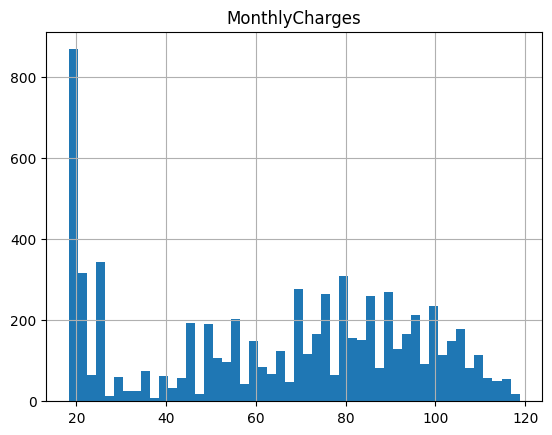

In [10]:
contract = load_dataset('contract_new.csv')
general_info(contract)

#### Переименование признаков

Переименуем признаки к формату `snake_case` по общепринятым для Python стандартам

In [11]:
contract.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [12]:
contract = clean_columns(contract)

8 column names have been cleaned

In [13]:
contract.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

#### Анализ признаков

#####  `begin_date`

In [14]:
contract.begin_date.nunique()

77

In [15]:
contract.begin_date.sort_values().unique()

array(['2013-10-01', '2013-11-01', '2013-12-01', '2014-01-01',
       '2014-02-01', '2014-03-01', '2014-04-01', '2014-05-01',
       '2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01',
       '2014-10-01', '2014-11-01', '2014-12-01', '2015-01-01',
       '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01',
       '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01',
       '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01',
       '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01',
       '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01',
       '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01',
       '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
       '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
       '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
       '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
       '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
       '2018-10-01', '2018-11-01', '2018-12-01', '2019-

In [16]:
with pd.option_context('display.max_rows', None):
    print(contract.begin_date.value_counts().sort_index())

2013-10-01      3
2013-11-01      2
2013-12-01      3
2014-01-01      7
2014-02-01    366
2014-03-01    178
2014-04-01    114
2014-05-01     98
2014-06-01     97
2014-07-01     98
2014-08-01     82
2014-09-01     72
2014-10-01     80
2014-11-01     77
2014-12-01     75
2015-01-01     75
2015-02-01     80
2015-03-01     58
2015-04-01     69
2015-05-01     74
2015-06-01     79
2015-07-01     61
2015-08-01     66
2015-09-01     67
2015-10-01     81
2015-11-01     74
2015-12-01     68
2016-01-01     57
2016-02-01     73
2016-03-01     61
2016-04-01     73
2016-05-01     68
2016-06-01     59
2016-07-01     58
2016-08-01     67
2016-09-01     74
2016-10-01     65
2016-11-01     50
2016-12-01     58
2017-01-01     64
2017-02-01     55
2017-03-01     94
2017-04-01     66
2017-05-01     66
2017-06-01     62
2017-07-01     65
2017-08-01     71
2017-09-01     73
2017-10-01     57
2017-11-01     82
2017-12-01     90
2018-01-01     73
2018-02-01     91
2018-03-01     89
2018-04-01     81
2018-05-01

##### `end_date`

In [17]:
contract.end_date.nunique()

67

In [18]:
contract.end_date.sort_values().unique()

array(['2014-06-01', '2014-09-01', '2014-10-01', '2014-11-01',
       '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01',
       '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01',
       '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01',
       '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01',
       '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01',
       '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01',
       '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01',
       '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
       '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01',
       '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01',
       '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
       '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
       '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01',
       '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
       '2019-08-01', '2019-09-01', '2019-10-01', '2019-

In [19]:
with pd.option_context('display.max_rows', None):
    print(contract.end_date.value_counts().sort_index())

2014-06-01       1
2014-09-01       2
2014-10-01       1
2014-11-01       1
2014-12-01       2
2015-01-01       5
2015-02-01       4
2015-03-01       3
2015-04-01       2
2015-05-01       3
2015-06-01       3
2015-07-01       5
2015-08-01       7
2015-09-01       6
2015-10-01       9
2015-11-01       8
2015-12-01       7
2016-01-01       6
2016-02-01       7
2016-03-01      11
2016-04-01       8
2016-05-01       9
2016-06-01      13
2016-07-01      20
2016-08-01      11
2016-09-01      14
2016-10-01      16
2016-11-01      13
2016-12-01      12
2017-01-01      12
2017-02-01      15
2017-03-01      20
2017-04-01      19
2017-05-01      22
2017-06-01      16
2017-07-01      20
2017-08-01      18
2017-09-01      23
2017-10-01      21
2017-11-01      26
2017-12-01      23
2018-01-01      13
2018-02-01      21
2018-03-01      24
2018-04-01      18
2018-05-01      24
2018-06-01      26
2018-07-01      27
2018-08-01      23
2018-09-01      28
2018-10-01      21
2018-11-01      35
2018-12-01  

In [20]:
contract[contract.end_date != 'No'].end_date.count()

1101

##### `type`

In [21]:
contract.type.nunique()

3

In [22]:
contract.type.unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [23]:
contract.type.value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

##### `paperless_billing`

In [24]:
contract.paperless_billing.nunique()

2

In [25]:
contract.paperless_billing.unique()

array(['Yes', 'No'], dtype=object)

In [26]:
contract.paperless_billing.value_counts()

Yes    4171
No     2872
Name: paperless_billing, dtype: int64

##### `payment_method`

In [27]:
contract.payment_method.nunique()

4

In [28]:
contract.payment_method.unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [29]:
contract.payment_method.value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64

##### `monthly_charges`

In [30]:
contract.monthly_charges.nunique()

1585

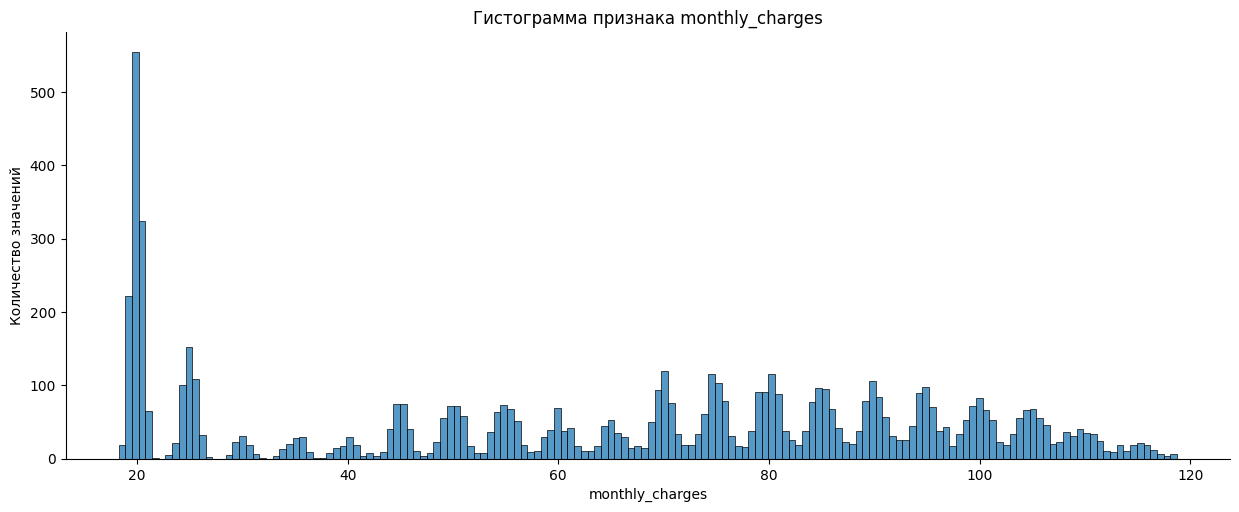

In [31]:
sns.displot(
    contract.monthly_charges,
    bins=contract.monthly_charges.nunique()//10,
    height=5,
    aspect=2.5
)
plt.ylabel('Количество значений')
plt.xlabel('monthly_charges')
plt.title('Гистограмма признака monthly_charges');

##### `total_charges`

In [32]:
try:
    contract = contract.astype({
        'total_charges': 'float64'
    })
except:
    print('[ERROR] Ошибка преобразоания типа данных!')

[ERROR] Ошибка преобразоания типа данных!


In [33]:
contract.total_charges.nunique()

6658

In [34]:
contract.total_charges.sort_values().unique()

array([' ', '100.17', '100.19', ..., '998.89', '999.6', '999.9'],
      dtype=object)

In [35]:
contract.total_charges.value_counts()

           11
20.45       6
101.0       5
21.53       4
40.1        4
           ..
4357.5      1
3509.55     1
2530.8      1
2599.1      1
7251.82     1
Name: total_charges, Length: 6658, dtype: int64

In [36]:
contract[contract.total_charges == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


In [37]:
contract[contract.begin_date == '2020-02-01']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Предаврительный вывод по признаку `total_charges`:
 - наиболее вероятно признак должен содержать только количественные значения, но содержит 5 строк с пустой строкой в качестве значения - ' ', это пропущенные значения;
 - пропущенные значения только для записей, у которых в признаке `begin_date` значение `2020-02-01`; 
    - в датасете только эти 11 записей (с пропуском в `total_charges`) со значением `2020-02-01` в признаке `begin_date`;
    - можно предположить, что произошла какая-то техническая ошибка в момент заполнения/расчёта значения `total_charges` для записей со значением `2020-02-01` в признаке `begin_date`;

Предположения как можно обработать пропуски в `total_charges`:
 1. данный количественный признак можно преобраовать в категориальный, разделить на категории, например, `low total charges`, `medium total charges`, `high total charges`, а для пропусков добавить значение `undefined`
 2. другой вариант удалить такие записи, так как их очень мало

#### Выводы

 - датасет содержит 7043 записи с 8 признаками;
 - признаки:
    - `customer_id` - признак общий для всех датасетов - 
    - `begin_date` - содержит только даты от '2013-10-01' до '2020-01-01' - месяц в определённом году
    - `end_date` - содержит даты - месяц в определённом году, и значение `No`. __Предположительно на основе данного признака можно сформировать целевую переменную - факт того отказался ли клиент от услуг связи__; 
      - из 7043 записей 5942 с значение `No`, 1101 запись содержит дату;
    - `type`, `paperless_billing`, `payment_method` категориальные переменные
    - `monthly_charges` - количественная переменная
    - `total_charges` - количественная переменная, но содержит пустые значения - значения пробела ' ';
  - только признак `total_charges` содержит пустые значения, таких записей всего 11;
     - данный количественный признак можно преобраовать в категориальный, разделить на категории, например, `low total charges`, `medium total charges`, `high total charges`, а для пропусков добавить значение `undefined`
     - другой вариант удалить такие записи, так как их очень мало;
 - датасет не содержит полных дубликатов, и дубликатов по признаку `customer_id`.

### Датасет `personal_new.csv`

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 7043   │ │ string      │ 4     │                                                          │
│ │ Number of columns │ 5      │ │ int32       │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┓  │
│ ┃ column_name           ┃ NA    ┃ NA %    ┃ mean    ┃ sd      ┃ p0   ┃ p25    ┃ p75    ┃ p100    ┃ hist      ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━┩  │
│ │ SeniorCitizen         │     0 │       0 │    0.16 │    0.37 │    0 │      0 │      0 │       1 │  █    ▂   │  │
│ └───────────────────────┴───────┴─────────┴─────────┴─────────┴──────┴────────┴────────┴─────────┴───────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ customerID                │       0 │          0 │                            1 │                     7000 │  │
│ │ gender                    │       0 │          0 │                            1 │                     7000 │  │
│ │ Partner                   │       0 │          0 │                            1 │                     7000 │  │
│ │ Dependents                │       0 │          0 │                            1 │                     7000 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.00,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.16,NaN,NaN
std,NaN,NaN,0.37,NaN,NaN
min,NaN,NaN,0.00,NaN,NaN
25%,NaN,NaN,0.00,NaN,NaN
50%,NaN,NaN,0.00,NaN,NaN
75%,NaN,NaN,0.00,NaN,NaN


Гистограммы признаков


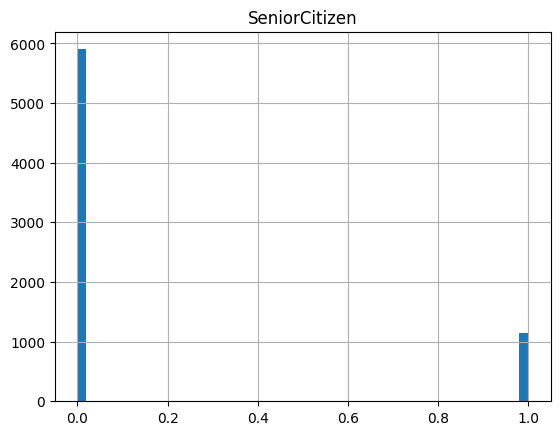

In [38]:
personal = load_dataset('personal_new.csv')
general_info(personal)

#### Переименование признаков

In [39]:
personal.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

In [40]:
personal = clean_columns(personal)

4 column names have been cleaned

In [41]:
personal.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

#### Анализ признаков

##### `gender`

In [42]:
personal.gender.nunique()

2

In [43]:
personal.gender.unique()

array(['Female', 'Male'], dtype=object)

In [44]:
personal.gender.value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

##### `senior_citizen`

In [45]:
personal.senior_citizen.nunique()

2

In [46]:
personal.senior_citizen.unique()

array([0, 1], dtype=int64)

In [47]:
personal.senior_citizen.value_counts()

0    5901
1    1142
Name: senior_citizen, dtype: int64

##### `partner`

In [48]:
personal.partner.nunique()

2

In [49]:
personal.partner.unique()

array(['Yes', 'No'], dtype=object)

In [50]:
personal.partner.value_counts()

No     3641
Yes    3402
Name: partner, dtype: int64

##### `dependents`

In [51]:
personal.dependents.nunique()

2

In [52]:
personal.dependents.unique()

array(['No', 'Yes'], dtype=object)

In [53]:
personal.dependents.value_counts()

No     4933
Yes    2110
Name: dependents, dtype: int64

#### Выводы

 - датасет содержит 7043 записи с 5 признаками;
 - признаки:
    - `customer_id` - признак общий для всех датасетов - 
    - `gender`, `senior_citizen`, `partner`, `dependents` - категориальные признаки;
 - признаки не содержат пропусков;
 - датасет не содержит полных дубликатов, и дубликатов по признаку `customer_id`.

### Датасет `internet_new.csv`

In [54]:
internet = load_dataset('internet_new.csv')
general_info(internet)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 5517   │ │ string      │ 8     │                                                          │
│ │ Number of columns │ 8      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                      ┃ NA     ┃ NA %      ┃ words per row              ┃ total words           ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ customerID                       │      0 │         0 │                          1 │                  5500 │  │
│ │ InternetService                  │      0 │         0 │                          1 │                  5500 │  │
│ │ OnlineSecurity                   │      0 │         0 │                          1 │                  5500 │  │
│ │ OnlineBackup                     │      0 │         0 │                          1 │                  5500 │  │
│ │ DeviceProtection                 │      0 │         0 │                          1 │                  5500 │  │
│ │ TechSupport                      │      0 │         0 │                          1 │                  5500 │  │
│ │ StreamingTV                      │      0 │         0 │                          1 │                  5500 │  │
│ │ StreamingMovies                  │      0 │         0 │                          1 │                  5500 │  │
│ └──────────────────────────────────┴────────┴───────────┴────────────────────────────┴───────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


#### Переименование признаков

In [55]:
internet.columns

Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [56]:
internet = clean_columns(internet)

8 column names have been cleaned

In [57]:
internet.columns

Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

#### Анализ признаков

##### `internet_service`

In [58]:
internet.internet_service.nunique()

2

In [59]:
internet.internet_service.unique()

array(['DSL', 'Fiber optic'], dtype=object)

In [60]:
internet.internet_service.value_counts()

Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64

##### `online_security`

In [61]:
internet.online_security.nunique()

2

In [62]:
internet.online_security.unique()

array(['No', 'Yes'], dtype=object)

In [63]:
internet.online_security.value_counts()

No     3498
Yes    2019
Name: online_security, dtype: int64

##### `online_backup`

In [64]:
internet.online_backup.nunique()

2

In [65]:
internet.online_backup.unique()

array(['Yes', 'No'], dtype=object)

In [66]:
internet.online_backup.value_counts()

No     3088
Yes    2429
Name: online_backup, dtype: int64

##### `device_protection`

In [67]:
internet.device_protection.nunique()

2

In [68]:
internet.device_protection.unique()

array(['No', 'Yes'], dtype=object)

In [69]:
internet.device_protection.value_counts()

No     3095
Yes    2422
Name: device_protection, dtype: int64

##### `tech_support`

In [70]:
internet.tech_support.nunique()

2

In [71]:
internet.tech_support.unique()

array(['No', 'Yes'], dtype=object)

In [72]:
internet.tech_support.value_counts()

No     3473
Yes    2044
Name: tech_support, dtype: int64

##### `streaming_tv`

In [73]:
internet.streaming_tv.nunique()

2

In [74]:
internet.streaming_tv.unique()

array(['No', 'Yes'], dtype=object)

In [75]:
internet.streaming_tv.value_counts()

No     2810
Yes    2707
Name: streaming_tv, dtype: int64

##### `streaming_movies`

In [76]:
internet.streaming_movies.nunique()

2

In [77]:
internet.streaming_movies.unique()

array(['No', 'Yes'], dtype=object)

In [78]:
internet.streaming_movies.value_counts()

No     2785
Yes    2732
Name: streaming_movies, dtype: int64

#### Выводы

 - датасет содержит 5517 записи с 8 признаками;
 - признаки:
    - `customer_id` - признак общий для всех датасетов - 
    - все остальные признаки `internet_service`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies` категориальные, и при этом бинарные;
 - признаки не содержат пропусков;
 - датасет не содержит полных дубликатов, и дубликатов по признаку `customer_id`.

### Датасет `phone_new.csv`

In [79]:
phone = load_dataset('phone_new.csv')
general_info(phone)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 6361   │ │ string      │ 2     │                                                          │
│ │ Number of columns │ 2      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                  ┃ NA     ┃ NA %       ┃ words per row               ┃ total words             ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ customerID                   │      0 │          0 │                           1 │                    6400 │  │
│ │ MultipleLines                │      0 │          0 │                           1 │                    6400 │  │
│ └──────────────────────────────┴────────┴────────────┴─────────────────────────────┴─────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


#### Переименование признаков

In [80]:
phone.columns

Index(['customerID', 'MultipleLines'], dtype='object')

In [81]:
phone = clean_columns(phone)

2 column names have been cleaned

In [82]:
phone.columns

Index(['customer_id', 'multiple_lines'], dtype='object')

#### Анализ признаков

##### `multiple_lines`

In [83]:
phone.multiple_lines.nunique()

2

In [84]:
phone.multiple_lines.unique()

array(['No', 'Yes'], dtype=object)

In [85]:
phone.multiple_lines.value_counts()

No     3390
Yes    2971
Name: multiple_lines, dtype: int64

#### Выводы

 - датасет содержит 6361 записи с 2 признаками;
 - признаки:
    - `customer_id` - признак общий для всех датасетов - 
    - `multiple_lines` категориальный бинарный признак;
 - признаки не содержат пропусков;
 - датасет не содержит полных дубликатов, и дубликатов по признаку `customer_id`.

### Общий вывод по предварительному анализу

Датасет `contract_new.csv`
 - датасет содержит 7043 записи с 8 признаками;
 - признаки:
    - `customer_id` - признак общий для всех датасетов - 
    - `begin_date` - содержит только даты от '2013-10-01' до '2020-01-01' - месяц в определённом году
    - `end_date` - содержит даты - месяц в определённом году, и значение `No`. __Предположительно на основе данного признака можно сформировать целевую переменную - факт того отказался ли клиент от услуг связи__; 
      - из 7043 записей 5942 с значение `No`, 1101 запись содержит дату;
    - `type`, `paperless_billing`, `payment_method` категориальные переменные
    - `monthly_charges` - количественная переменная
    - `total_charges` - количественная переменная, но содержит пустые значения - значения пробела ' ';
  - только признак `total_charges` содержит пустые значения, таких записей всего 11;
     - данный количественный признак можно преобраовать в категориальный, разделить на категории, например, `low total charges`, `medium total charges`, `high total charges`, а для пропусков добавить значение `undefined`
     - другой вариант удалить такие записи, так как их очень мало;
 - датасет не содержит полных дубликатов, и дубликатов по признаку `customer_id`.

Датасет `personal_new.csv`
 - датасет содержит 7043 записи с 5 признаками;
 - признаки:
    - `customer_id` - признак общий для всех датасетов - 
    - `gender`, `senior_citizen`, `partner`, `dependents` - категориальные признаки;
 - признаки не содержат пропусков;
 - датасет не содержит полных дубликатов, и дубликатов по признаку `customer_id`.
 
Датасет `internet_new.csv`
 - датасет содержит 5517 записи с 8 признаками;
 - признаки:
    - `customer_id` - признак общий для всех датасетов - 
    - все остальные признаки `internet_service`, `online_security`, `online_backup`, `device_protection`, `tech_support`, `streaming_tv`, `streaming_movies` категориальные, и при этом бинарные;
 - признаки не содержат пропусков;
 - датасет не содержит полных дубликатов, и дубликатов по признаку `customer_id`.

Датасет `phone_new.csv`
 - датасет содержит 6361 записи с 2 признаками;
 - признаки:
    - `customer_id` - признак общий для всех датасетов - 
    - `multiple_lines` категориальный бинарный признак;
 - признаки не содержат пропусков;
 - датасет не содержит полных дубликатов, и дубликатов по признаку `customer_id`.




 - Для дальнейшей работы над проектом датасеты необходимо соединить по признаку `customer_id`. Два из четырёх датасетов содержат 7043 записей, оставшиеся два меньше. Датасеты нужно будет соединить методом 'left join' начиная с датасета `contract_new.csv`.


## Предобработка данных

### Объединение датасетов

In [86]:
data = (
    contract
    .merge(personal, how='left', on='customer_id')
    .merge(internet, how='left', on='customer_id')
    .merge(phone, how='left', on='customer_id')
)

In [87]:
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

### Обработка пропусков

In [89]:
data.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

Пропуски пояявились послия слияния датасетов в результате того, что не все клиенты пользовались дополнительными услугами, и об этих клиентах не было записей в датасетах `internet_new.csv` и `phone_new.csv`. Заполним пропуски значением `No`.

In [90]:
data.fillna('No', inplace=True)

In [91]:
data.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64

#### Пропуски в `total_charges`

В предварительном анализе было обнаружено, что признак `total_charges` имеет пропуски в виде значений пробела ' '. Таких записей 11. Удалим такие записи и преобразуем тип признака к количчественному.

In [92]:
data.total_charges.where(data.total_charges != ' ', float('Nan'), inplace=True);

In [93]:
data.isna().sum()

customer_id           0
begin_date            0
end_date              0
type                  0
paperless_billing     0
payment_method        0
monthly_charges       0
total_charges        11
gender                0
senior_citizen        0
partner               0
dependents            0
internet_service      0
online_security       0
online_backup         0
device_protection     0
tech_support          0
streaming_tv          0
streaming_movies      0
multiple_lines        0
dtype: int64

In [94]:
data.dropna(subset='total_charges', inplace=True)

In [95]:
data.total_charges.describe()

count      7032
unique     6657
top       20.45
freq          6
Name: total_charges, dtype: object

In [96]:
data.total_charges = data.total_charges.astype('float64')

In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7032 non-null   object 
 1   begin_date         7032 non-null   object 
 2   end_date           7032 non-null   object 
 3   type               7032 non-null   object 
 4   paperless_billing  7032 non-null   object 
 5   payment_method     7032 non-null   object 
 6   monthly_charges    7032 non-null   float64
 7   total_charges      7032 non-null   float64
 8   gender             7032 non-null   object 
 9   senior_citizen     7032 non-null   int64  
 10  partner            7032 non-null   object 
 11  dependents         7032 non-null   object 
 12  internet_service   7032 non-null   object 
 13  online_security    7032 non-null   object 
 14  online_backup      7032 non-null   object 
 15  device_protection  7032 non-null   object 
 16  tech_support       7032 

### Подготовка целевого признака

In [98]:
data['target'] = data.end_date != 'No'
data.target = data.target.astype(int)

Целевой признак `target` со значениями:
 - `0` - клиент, всё ещё пользующиеся услугами компании на момент выгрузки даннных
 - `1` - уже ушедшие клиенты

In [99]:
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0


In [100]:
data.target.value_counts(1).round(2)

0    0.84
1    0.16
Name: target, dtype: float64

Классы целевого признакак несбалансированны

### Преобразование типа данных признаков с датами

In [101]:
data.begin_date = pd.to_datetime(data.begin_date, format='%Y-%m-%d')

In [102]:
data.end_date = pd.to_datetime(data.end_date, errors='coerce', format='%Y-%m-%d')

In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7032 non-null   object        
 9   senior_citizen     7032 non-null   int64         
 10  partner            7032 non-null   object        
 11  dependents         7032 non-null   object        
 12  internet_service   7032 non-null   object        
 13  online_security    7032 non-null   object        
 14  online_b

### Преобразование типа данных признака `senior_citizen`

In [104]:
data.senior_citizen.dtype

dtype('int64')

In [105]:
data.senior_citizen = data.senior_citizen.astype('object')

In [106]:
data.senior_citizen.dtype

dtype('O')

In [107]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           1101 non-null   datetime64[ns]
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7032 non-null   object        
 9   senior_citizen     7032 non-null   object        
 10  partner            7032 non-null   object        
 11  dependents         7032 non-null   object        
 12  internet_service   7032 non-null   object        
 13  online_security    7032 non-null   object        
 14  online_b

### Создание новых признаков

In [108]:
data.loc[data.end_date.isna(), 'end_date'] = '2020-02-01'

In [109]:
data['days_in_company'] = ((data.end_date - data.begin_date).dt.days).astype(int)

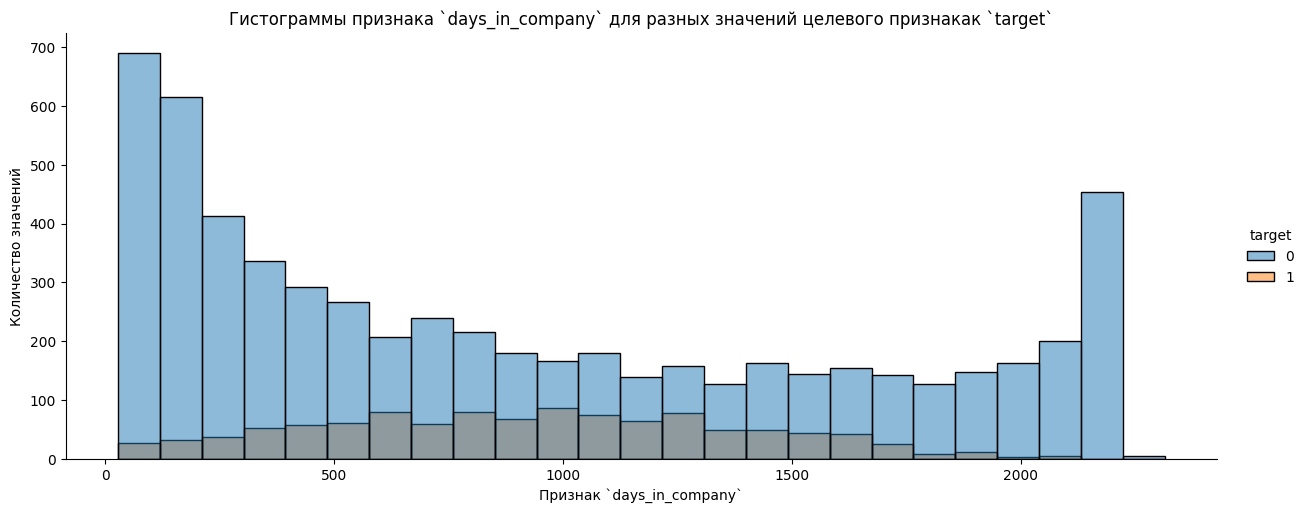

In [110]:
sns.displot(
    data=data,
    x=data.days_in_company,
    bins=data.days_in_company.nunique()//10,
    hue='target',
    height=5,
    aspect=2.5
)
plt.ylabel('Количество значений')
plt.xlabel('Признак `days_in_company`')
plt.title('Гистограммы признака `days_in_company` '
          + 'для разных значений целевого признакак `target`');

Из гистограмм видно, что распределение признака `days_in_company` для разных значений целевого признакак различаются. То есть можно предположить, что этот признак будет значим при обучении.

### Удаление неинформативных признаков

In [111]:
data.drop(columns=['customer_id', 'begin_date', 'end_date'], inplace=True)

### Дополнительный анализ

#### Портрет клиента

In [112]:
data_target_0 = data[data.target == 0]
data_target_1 = data[data.target == 1]

In [113]:
data_target_0.shape, data_target_1.shape

((5931, 19), (1101, 19))

Ниже портрет клиента, пользующегося услугами

In [114]:
data_target_0.describe(include='object').loc['top']

type                   Month-to-month
paperless_billing                 Yes
payment_method       Electronic check
gender                           Male
senior_citizen                      0
partner                            No
dependents                         No
internet_service          Fiber optic
online_security                    No
online_backup                      No
device_protection                  No
tech_support                       No
streaming_tv                       No
streaming_movies                   No
multiple_lines                     No
Name: top, dtype: object

In [115]:
data_target_0.describe(include='number').loc['mean']

monthly_charges      62.803043
total_charges      2071.701614
target                0.000000
days_in_company     895.338560
Name: mean, dtype: float64

Ниже портрет клиента, переставшего пользоваться услугами

In [116]:
data_target_1.describe(include='object').loc['top']

type                   Month-to-month
paperless_billing                 Yes
payment_method       Electronic check
gender                           Male
senior_citizen                      0
partner                           Yes
dependents                         No
internet_service          Fiber optic
online_security                    No
online_backup                     Yes
device_protection                  No
tech_support                       No
streaming_tv                      Yes
streaming_movies                  Yes
multiple_lines                    Yes
Name: top, dtype: object

In [117]:
data_target_1.describe(include='number').loc['mean']

monthly_charges      75.546004
total_charges      2371.377275
target                1.000000
days_in_company     924.863760
Name: mean, dtype: float64

#### Количественные признаки

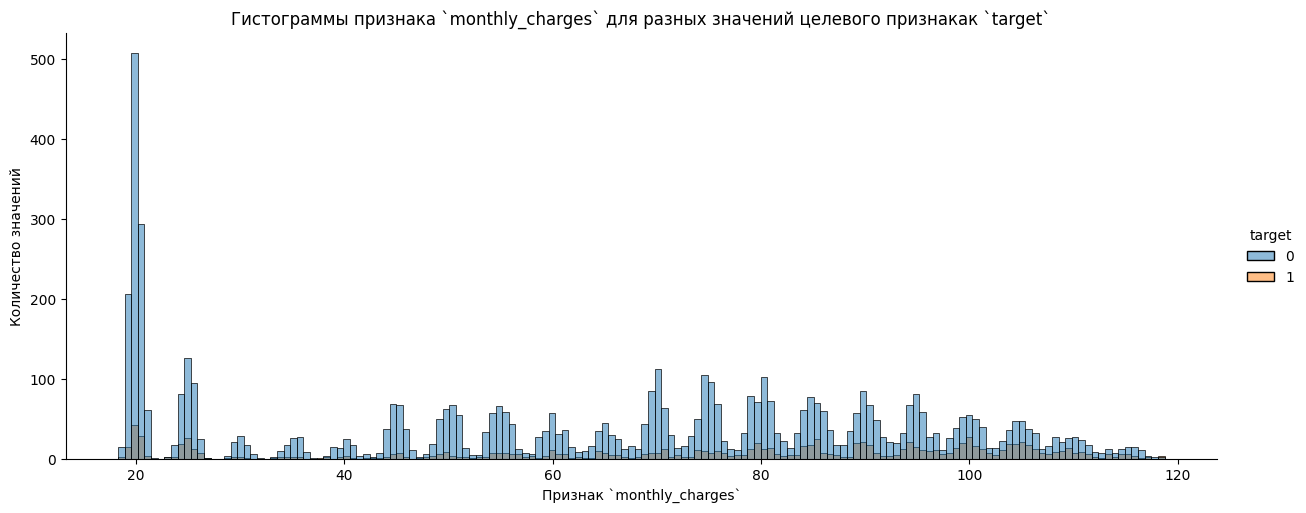

In [118]:
sns.displot(
    data=data,
    x=data.monthly_charges,
    bins=data.monthly_charges.nunique()//10,
    hue='target',
    height=5,
    aspect=2.5
)
plt.ylabel('Количество значений')
plt.xlabel('Признак `monthly_charges`')
plt.title('Гистограммы признака `monthly_charges` '
          + 'для разных значений целевого признакак `target`');

Из графика видно, что формы распределений признака `monthly_charges` для разных значений целевого признакак схожи, при этом отличаются по амплитуде.

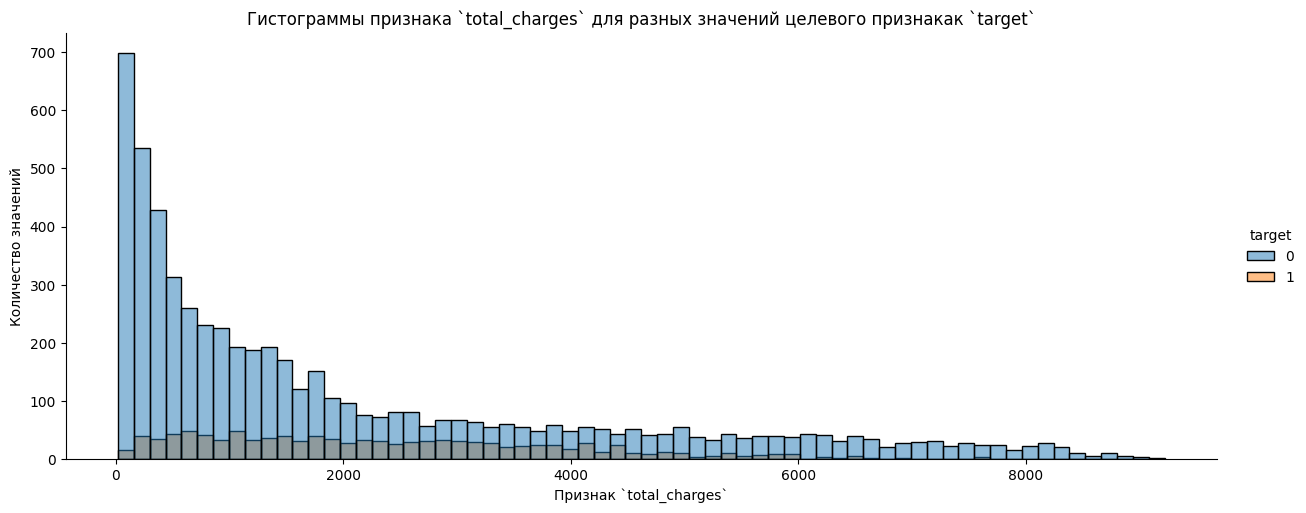

In [119]:
sns.displot(
    data=data,
    x=data.total_charges,
    bins=contract.total_charges.nunique()//100,
    hue='target',
    height=5,
    aspect=2.5
)
plt.ylabel('Количество значений')
plt.xlabel('Признак `total_charges`')
plt.title('Гистограммы признака `total_charges` для разных значений целевого признакак `target`');

Формы распределений признака `total_charges` для разных значений целевого признакак имею различия в начале шкалы значений.

####  Категориальные признаки

In [120]:
categorical_features = data.select_dtypes(exclude=[np.number]).columns.to_list()
categorical_features

['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

In [121]:
len(categorical_features)

15

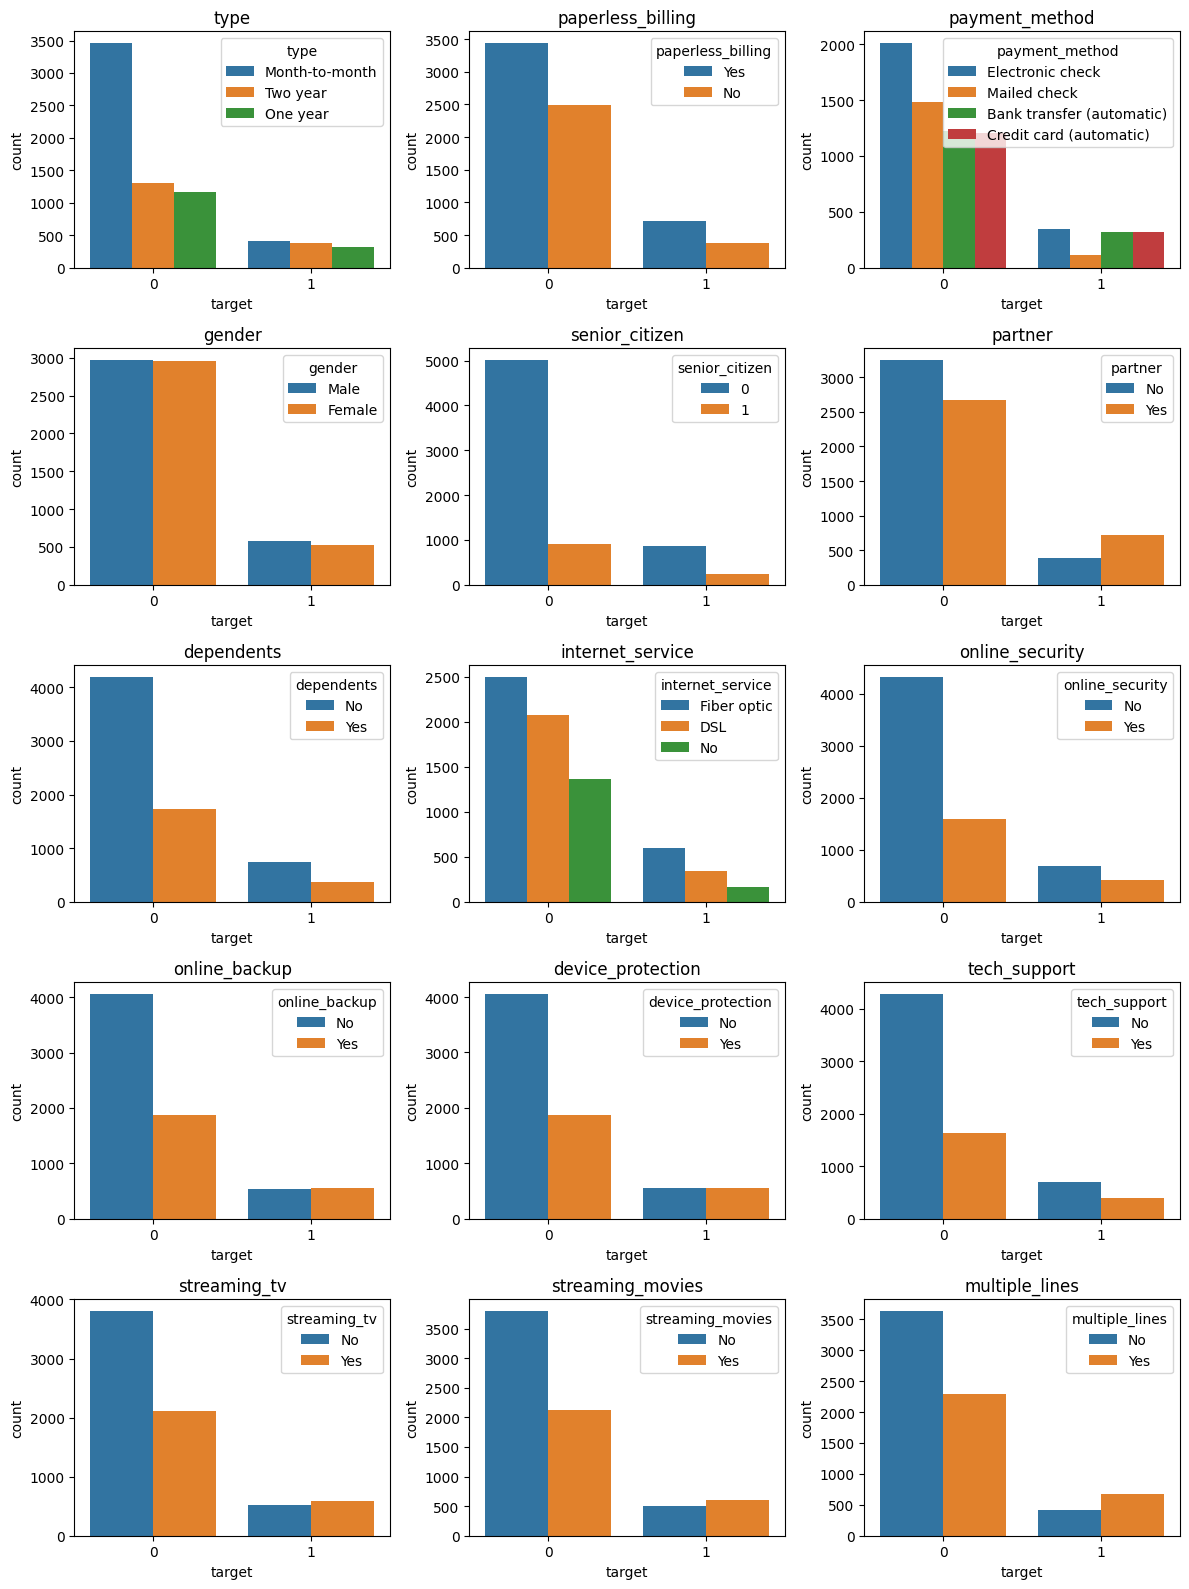

In [122]:
fig, axs = plt.subplots(len(categorical_features) // 3, 3, figsize=(12, 16))
axs = axs.flatten()

for feature, ax in zip(categorical_features, axs):
    counts = pd.DataFrame(data[['target', feature]].value_counts())
    counts.reset_index(inplace=True)
    counts = counts.rename(columns = {0:'count'})

    sns.barplot(
        data=counts,
        x='target',
        y='count',
        hue=feature,
        ax=ax
    )
    ax.set_title(feature)

plt.tight_layout()
plt.show()

Из анализа распределний категориальных признаков видно, что:
 1. 
    - ряд признаков имеют __схожие распределения__ значений при разных значения целевого признака, это признаки:
        - `paperless_billing`
        - `gender`
        - `senior_citizen`
        - `internet_service`
    - можно предположить, что данные признаки будут иметь малую важность при обучении;
 2. 
    - оставшиеся признаки имеют __разные распределения__ значений при разных значения целевого признака, это признаки:
    - соответственно можно предположить, что эти признаки будут иметь более высокую важность при обучении.

#### Корреляция признаков

In [123]:
numeric_features = data.select_dtypes([np.number]).columns.to_list()
numeric_features.remove('target')
numeric_features

['monthly_charges', 'total_charges', 'days_in_company']

In [124]:
phik_overview = data.phik_matrix(interval_cols=numeric_features)

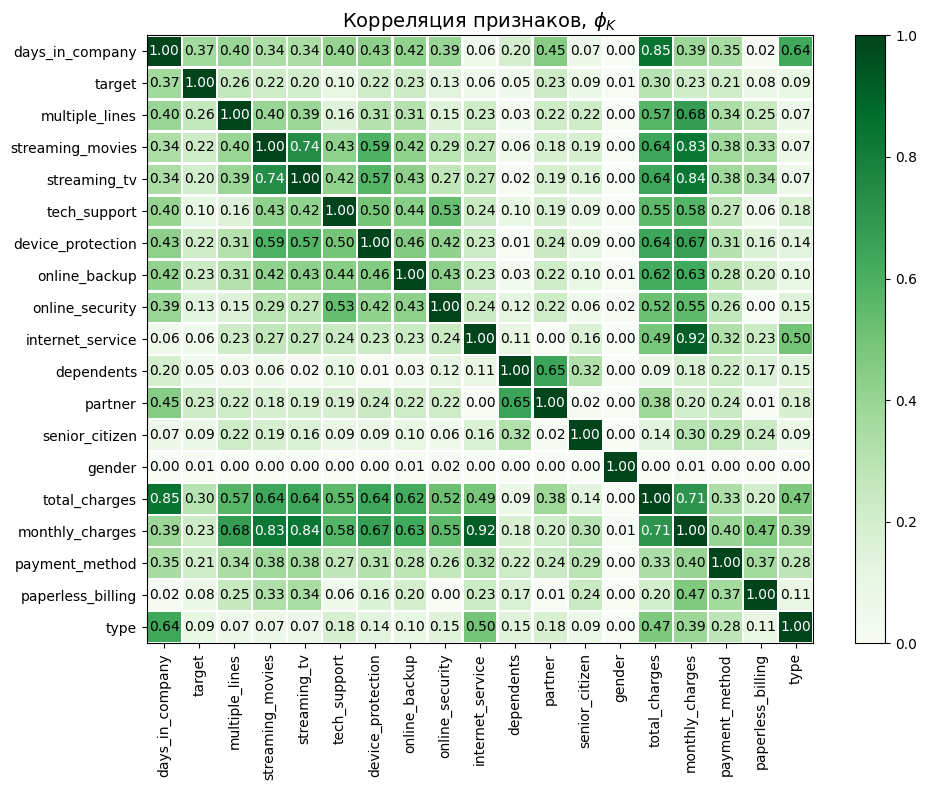

In [125]:
plot_correlation_matrix(
    phik_overview.values, 
    x_labels=phik_overview.columns, 
    y_labels=phik_overview.index, 
    vmin=0, vmax=1,
    color_map='Greens', 
    title=r'Корреляция признаков, $\phi_K$', 
    figsize=(10, 8)
)
plt.tight_layout()

In [126]:
%%time
significance_overview = data.significance_matrix(interval_cols=numeric_features)

CPU times: total: 47.5 s
Wall time: 52.8 s


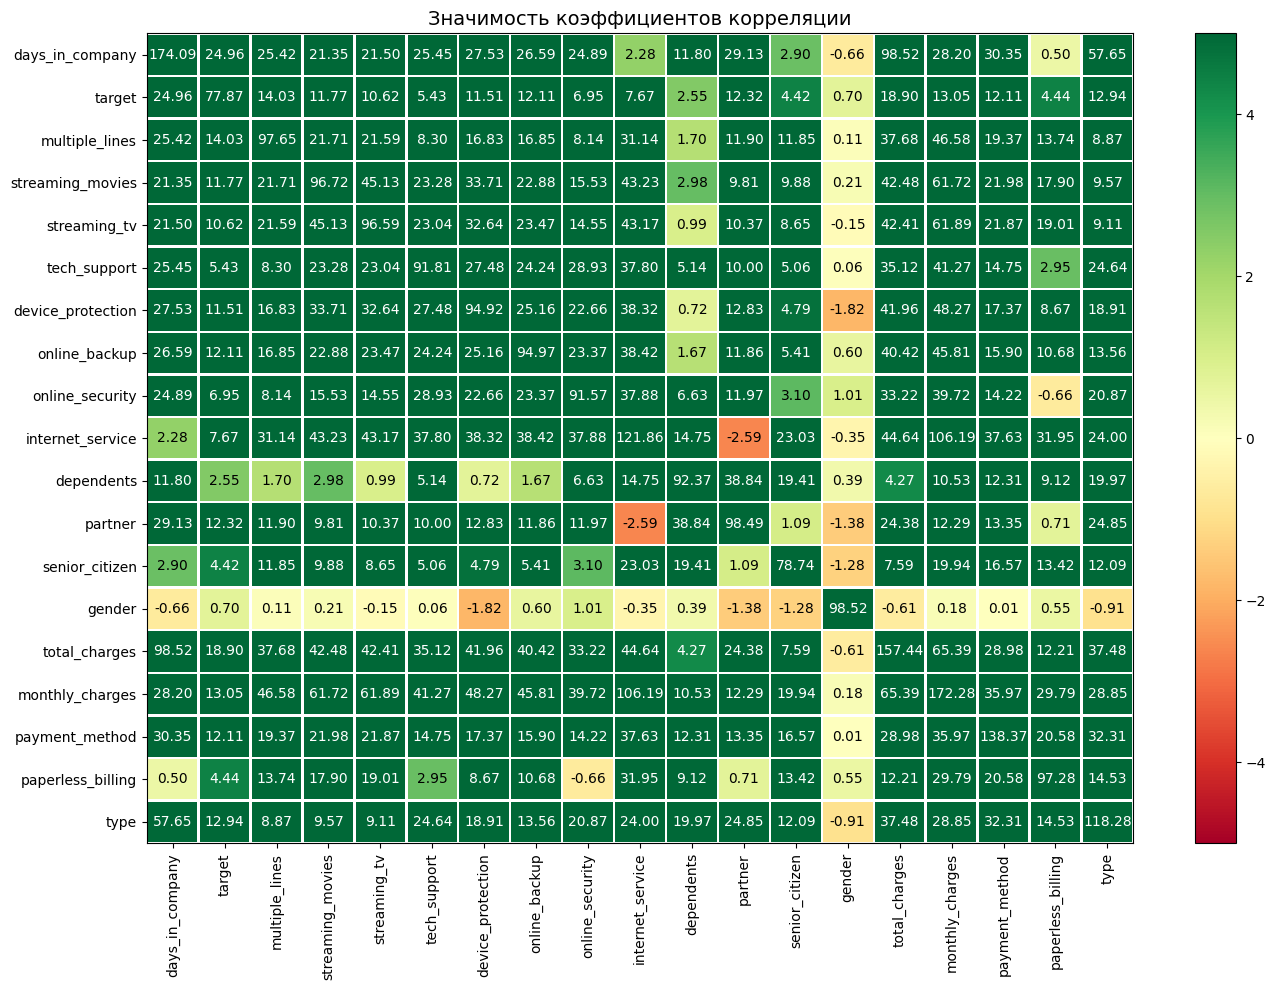

In [127]:
plot_correlation_matrix(
    significance_overview.fillna(0).values, 
    x_labels=significance_overview.columns, 
    y_labels=significance_overview.index, 
    vmin=-5, vmax=5,
    title='Значимость коэффициентов корреляции', 
    usetex=False,
    figsize=(14, 10)
)
plt.tight_layout()

Из анализа матрицы коррелция признаков (коэффициент корреляяци $\phi_K$ из научной работы [A new correlation coefficient between categorical, ordinal and interval variables with Pearson characteristics](https://arxiv.org/abs/1811.11440)) и анализа  матрицы значимость коэффициентов корреляции видно, что один признак `gender` практиччески не имеет взаимосвязи с другими признаками.

Удалим его.

#### Удаление признаков на основе анализа корреляции

In [128]:
data.drop(columns=['gender'], inplace=True)

In [129]:
data.columns

Index(['type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'senior_citizen', 'partner', 'dependents',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines', 'target', 'days_in_company'],
      dtype='object')

### Разбиение данных на выборки

In [130]:
target_name = 'target'

features = data.drop(columns=target_name)
target = data[target_name]

In [131]:
target.value_counts(1).round(2)

0    0.84
1    0.16
Name: target, dtype: float64

In [132]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE, stratify=target)

In [133]:
target_train.value_counts(1).round(2)

0    0.84
1    0.16
Name: target, dtype: float64

In [134]:
target_test.value_counts(1).round(2)

0    0.84
1    0.16
Name: target, dtype: float64

In [135]:
features_train.shape, target_train.shape

((5274, 17), (5274,))

In [136]:
features_test.shape, target_test.shape

((1758, 17), (1758,))

### Подготовка преобразований признаков

In [137]:
numeric_features = features_train.select_dtypes([np.number]).columns.to_list()
numeric_features

['monthly_charges', 'total_charges', 'days_in_company']

In [138]:
categorical_features = features_train.select_dtypes(exclude=[np.number]).columns.to_list()
categorical_features

['type',
 'paperless_billing',
 'payment_method',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

In [139]:
column_transformer = make_column_transformer(
    (
        MinMaxScaler(), 
        numeric_features
    ),
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        categorical_features
    ),
    verbose_feature_names_out=False
)

In [140]:
column_transformer.fit(features_train)

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 ['monthly_charges', 'total_charges',
                                  'days_in_company']),
                                ('onehotencoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['type', 'paperless_billing', 'payment_method',
                                  'senior_citizen', 'partner', 'dependents',
                                  'internet_service', 'online_security',
                                  'online_backup', 'device_protection',
                                  'tech_support', 'streaming_tv',
                                  'streaming_movies', 'multiple_lines'])],
                  verbose_feature_names_out=False)

In [141]:
features_train_tfr = pd.DataFrame(
    column_transformer.transform(features_train),
    columns=column_transformer.get_feature_names_out()
)
features_train_tfr.head()

,monthly_charges,total_charges,days_in_company,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,senior_citizen_1,partner_Yes,dependents_Yes,internet_service_Fiber optic,internet_service_No,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes
0,0.061753,0.006700,0.027997,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.061255,0.143802,0.719598,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.075697,0.200237,0.946194,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.479582,0.248017,0.427822,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
4,0.729084,0.018009,0.014873,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [142]:
features_train_tfr.shape, target_train.shape

((5274, 21), (5274,))

In [143]:
features_test_tfr = pd.DataFrame(
    column_transformer.transform(features_test),
    columns=column_transformer.get_feature_names_out()
)
features_test_tfr.head()

,monthly_charges,total_charges,days_in_company,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,senior_citizen_1,partner_Yes,dependents_Yes,internet_service_Fiber optic,internet_service_No,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes
0,0.665837,0.506689,0.720910,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.784363,0.757074,0.946194,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
2,0.556773,0.101419,0.147419,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.077191,0.192933,0.907262,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.911355,0.891215,0.946194,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


In [144]:
features_test_tfr.shape, target_test.shape

((1758, 21), (1758,))

## Обучение моделей

In [145]:
SCORE_NAME = 'AUC-ROC'

report_columns = [SCORE_NAME]

train_report = pd.DataFrame(columns=report_columns)
train_report['model'] = []
train_report.set_index('model', inplace=True)
train_report

,AUC-ROC
model,


In [146]:
def update_report(model_name, score):
    
    train_report.loc[model_name, SCORE_NAME] = np.float64(score).round(4)
    
    print('Результаты обучения модели', model_name)
    display(train_report.loc[model_name][[SCORE_NAME]])

In [147]:
def tune(objective, n_trials=10):
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, n_jobs=-1)

    best_score = study.best_value
    best_params = study.best_params
    print('Best score:', best_score)
    print('Best parameters:', best_params)
    print()
    return best_score, best_params

### Модель `LogisticRegression`

In [148]:
def log_reg_objective(trial):
    params = {}
    params['C'] = trial.suggest_float('C', 0.001, 10)
    
    params['random_state'] = RANDOM_STATE
    params['class_weight']='balanced'    

    model = LogisticRegression(**params)

    return cross_val_score(
        make_pipeline(column_transformer, model),
        features_train,
        target_train,
        cv=10,
        scoring='roc_auc',
        n_jobs=-1
    ).mean()

In [149]:
%%time
log_reg_score, log_reg_params = tune(log_reg_objective, n_trials=30)

[I 2023-05-30 18:51:52,566] A new study created in memory with name: no-name-3d9fd7a1-a91e-46a7-8714-90be3b687783
[I 2023-05-30 18:51:53,953] Trial 0 finished with value: 0.7619144781447046 and parameters: {'C': 1.3843246225530705}. Best is trial 0 with value: 0.7619144781447046.
[I 2023-05-30 18:51:53,973] Trial 1 finished with value: 0.7621676688459303 and parameters: {'C': 6.113705059022994}. Best is trial 1 with value: 0.7621676688459303.
[I 2023-05-30 18:51:54,697] Trial 4 finished with value: 0.7621867297800298 and parameters: {'C': 4.277436417924292}. Best is trial 4 with value: 0.7621867297800298.
[I 2023-05-30 18:51:54,993] Trial 2 finished with value: 0.7621619186931189 and parameters: {'C': 4.183917191552803}. Best is trial 4 with value: 0.7621867297800298.
[I 2023-05-30 18:51:55,223] Trial 5 finished with value: 0.7621703763049801 and parameters: {'C': 6.112076298097967}. Best is trial 4 with value: 0.7621867297800298.
[I 2023-05-30 18:51:55,263] Trial 3 finished with value

Best score: 0.7621867297800298
Best parameters: {'C': 4.277436417924292}

CPU times: total: 4.23 s
Wall time: 8.21 s


In [150]:
update_report(
    LogisticRegression.__name__,
    log_reg_score
)

Результаты обучения модели LogisticRegression


AUC-ROC    0.7622
Name: LogisticRegression, dtype: object

### Модель `RandomForestClassifier`

In [151]:
def random_forest_objective(trial):
    params = {}
    params['n_estimators'] = trial.suggest_int('n_estimators', 5, 500)
    params['max_depth'] = trial.suggest_int('max_depth', 2, 35)
    
    params['random_state'] = RANDOM_STATE
    params['class_weight']='balanced'
    params['n_jobs'] = -1

    model = RandomForestClassifier(**params)

    return cross_val_score(
        make_pipeline(column_transformer, model),
        features_train,
        target_train,
        cv=10,
        scoring='roc_auc',
        n_jobs=-1
    ).mean()

In [152]:
# %%time
# random_forest_score, random_forest_params = tune(random_forest_objective, n_trials=10)
# uncomment for tuning

In [153]:
# comment this cell when tuning
random_forest_score = 0.8175971644497599
random_forest_params = {'n_estimators': 338, 'max_depth': 6}
# the parameter values were obtained during the tuning

In [154]:
update_report(
    RandomForestClassifier.__name__,
    random_forest_score
)

Результаты обучения модели RandomForestClassifier


AUC-ROC    0.8176
Name: RandomForestClassifier, dtype: object

### Модель `CatBoostClassifier`

In [155]:
EARLY_STOPPING_ROUNDS = 100
FOLD_NUMBER = 5

In [156]:
def catboost_clf_objective(trial):
    params = {}
    params['iterations'] = trial.suggest_int('iterations', 10, 1000)
    params['learning_rate'] = trial.suggest_float('learning_rate', 0.1, 1)
    params['depth'] = trial.suggest_int('depth', 2, 7)
    params['l2_leaf_reg'] = trial.suggest_float('l2_leaf_reg', 0.001, 100)
    
    params['eval_metric'] = 'AUC'
    params['random_state'] = RANDOM_STATE
    params['logging_level'] = 'Silent'
    params['auto_class_weights'] = 'Balanced'
    
    kf = StratifiedKFold(
        n_splits = FOLD_NUMBER,
        random_state = RANDOM_STATE,
        shuffle = True
    )
    scores = []
    for i, (train_index, valid_index) in enumerate(kf.split(features_train_tfr, target_train)):
        
        X_train = features_train_tfr.loc[features_train_tfr.index[train_index]]
        y_train = target_train.loc[target_train.index[train_index]]
        X_valid = features_train_tfr.loc[features_train_tfr.index[valid_index]]
        y_valid = target_train.loc[target_train.index[valid_index]]
        
        model = CatBoostClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=(X_valid, y_valid),
            early_stopping_rounds=EARLY_STOPPING_ROUNDS
        )
        scores.append(
            roc_auc_score(
                y_valid,
                model.predict_proba(X_valid)[:, 1]
            )
        )
    
    return np.average(scores)

In [157]:
# %%time
# catboost_clf_score, catboost_clf_params = tune(catboost_clf_objective, n_trials=300)
# uncomment for tuning

In [158]:
# comment this cell when tuning
catboost_clf_score = 0.9315540565490158
catboost_clf_params = {'iterations': 902, 'learning_rate': 0.3196207761899325, 'depth': 2, 'l2_leaf_reg': 0.012772416091202166}
# the parameter values were obtained during the tuning

In [159]:
update_report(
    CatBoostClassifier.__name__,
    catboost_clf_score
)

Результаты обучения модели CatBoostClassifier


AUC-ROC    0.9316
Name: CatBoostClassifier, dtype: object

### Модель `XGBClassifier`

In [160]:
SCALE_POS_WEIGHT = float(np.sum(target == 0)) / np.sum(target == 1)

def xgb_clf_objective(trial):
    params = {}
    params['n_estimators'] = trial.suggest_int('n_estimators', 100, 1000)
    params['learning_rate'] = trial.suggest_float('learning_rate', 0.01, 1)
    params['max_depth'] = trial.suggest_int('max_depth', 2, 10)
    params['reg_alpha'] = trial.suggest_float('reg_alpha', 0.001, 1)
    params['reg_lambda'] = trial.suggest_float('reg_lambda', 0.001, 1)
    
    params['random_state'] = RANDOM_STATE
    params['n_jobs'] = -1
    params['scale_pos_weight'] = SCALE_POS_WEIGHT
    
    model = XGBClassifier(**params)  
    
    return cross_val_score(
        make_pipeline(column_transformer, model),
        features_train,
        target_train,
        cv=10,
        scoring='roc_auc',
        n_jobs=-1
    ).mean()

In [161]:
# %%time
# xgb_clf_score, xgb_clf_params = tune(xgb_clf_objective, n_trials=30)
# uncomment for tuning

In [162]:
# comment this cell when tuning
xgb_clf_score = 0.9207466029524392
xgb_clf_params = {
    'n_estimators': 798,
    'learning_rate': 0.502044207458034,
    'max_depth': 2,
    'reg_alpha': 0.913997220061226,
    'reg_lambda': 0.12627429653129338
}
# the parameter values were obtained during the tuning

In [163]:
update_report(
    XGBClassifier.__name__,
    xgb_clf_score
)

Результаты обучения модели XGBClassifier


AUC-ROC    0.9207
Name: XGBClassifier, dtype: object

### Модель `LGBMClassifier`

In [164]:
FOLD_NUMBER = 5

def lightgbm_clf_objective(trial):
    params = {}
    params['n_estimators'] = trial.suggest_int('iterations', 10, 1000)
    params['learning_rate'] = trial.suggest_float('learning_rate', 0.1, 1)
    params['max_depth'] = trial.suggest_int('max_depth', 1, 10)
    params['reg_alpha'] = trial.suggest_float('reg_alpha', 1, 300)
    params['reg_lambda'] = trial.suggest_float('reg_lambda', 1, 300)
    
    params['metric'] = 'auc'
    params['random_state'] = RANDOM_STATE
    params['n_jobs'] = -1
    params['class_weight']='balanced'
    
    kf = StratifiedKFold(
        n_splits = FOLD_NUMBER,
        random_state = RANDOM_STATE,
        shuffle = True
    )
    scores = []
    for i, (train_index, valid_index) in enumerate(kf.split(features_train_tfr, target_train)):
        
        X_train = features_train_tfr.loc[features_train_tfr.index[train_index]]
        y_train = target_train.loc[target_train.index[train_index]]
        X_valid = features_train_tfr.loc[features_train_tfr.index[valid_index]]
        y_valid = target_train.loc[target_train.index[valid_index]]
        
        model = LGBMClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric='auc',
            verbose=False
        )
        
        scores.append(
            roc_auc_score(
                y_valid,
                model.predict_proba(X_valid)[:, 1]
            )
        )
    
    return np.average(scores)  

In [165]:
# %%time
# lightgbm_clf_score, lightgbm_clf_params = tune(lightgbm_clf_objective, n_trials=300)
# uncomment for tuning

In [166]:
# comment this cell when tuning
lightgbm_clf_score = 0.8842316225725855
lightgbm_clf_params = {
    'iterations': 513,
    'learning_rate': 0.8054015715033498,
    'max_depth': 3,
    'reg_alpha': 1.410334184113838,
    'reg_lambda': 7.024028239041914
}
# the parameter values were obtained during the tuning

In [167]:
update_report(
    LGBMClassifier.__name__,
    lightgbm_clf_score
)

Результаты обучения модели LGBMClassifier


AUC-ROC    0.8842
Name: LGBMClassifier, dtype: object

In [168]:
train_report

,AUC-ROC
model,
LogisticRegression,0.7622
RandomForestClassifier,0.8176
CatBoostClassifier,0.9316
XGBClassifier,0.9207
LGBMClassifier,0.8842


## Тестирование лучшей модели

Лучшей модель на обучении стала модель `CatBoostClassifier`. Проверим её на тестовой выборке.

In [169]:
print('Параметры модели `CatBoostClassifier`:')
catboost_clf_params

Параметры модели `CatBoostClassifier`:


{'iterations': 902,
 'learning_rate': 0.3196207761899325,
 'depth': 2,
 'l2_leaf_reg': 0.012772416091202166}

In [170]:
catboost_clf = CatBoostClassifier(
    **catboost_clf_params,
    random_state=RANDOM_STATE,
    logging_level='Silent',
    auto_class_weights='Balanced'
)

In [171]:
catboost_clf.fit(features_train_tfr, target_train);

### Метрика `ROC AUC`

In [172]:
predicted_prob_test = catboost_clf.predict_proba(features_test_tfr)[:, 1]
roc_auc_test = roc_auc_score(target_test, predicted_prob_test).round(3)
print('ROC AUC на тестовой выборке: ', roc_auc_test)

ROC AUC на тестовой выборке:  0.928


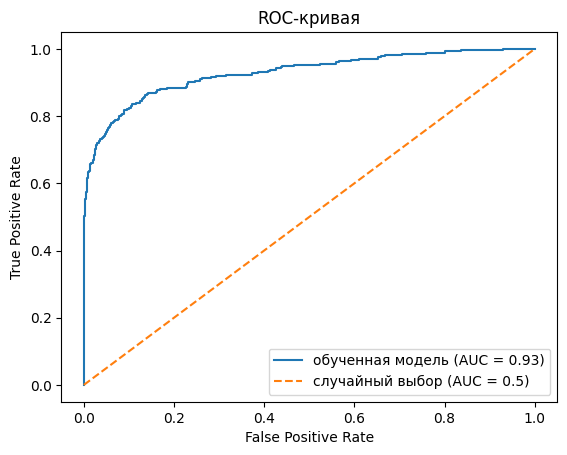

In [173]:
fpr, tpr, thresholds = roc_curve(target_test, predicted_prob_test)
roc_auc = auc(fpr, tpr)

disp = RocCurveDisplay(
    fpr=fpr, tpr=tpr,
    roc_auc=roc_auc,
    estimator_name='обученная модель'
)
disp.plot()

plt.plot(
    [0, 1], [0, 1], linestyle='--',
    label='случайный выбор (AUC = 0.5)'
)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.show()

### Метрика `accuracy` и матрица ошибок

In [174]:
predicted_test = catboost_clf.predict(features_test_tfr)
accuracy_test = accuracy_score(target_test, predicted_test).round(3)
print('Accuracy на тестовой выборке: ', accuracy_test)

Accuracy на тестовой выборке:  0.908


In [175]:
print(classification_report(target_test, predicted_test))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1483
           1       0.68      0.79      0.73       275

    accuracy                           0.91      1758
   macro avg       0.82      0.86      0.84      1758
weighted avg       0.92      0.91      0.91      1758



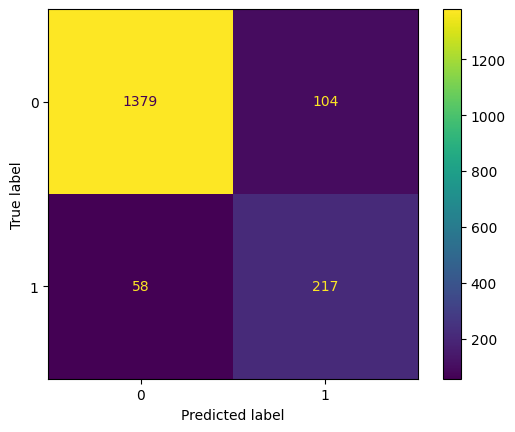

In [176]:
cm = confusion_matrix(target_test, predicted_test)

ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=catboost_clf.classes_
).plot();

Из анализа матрицы ошибок и отчёта по классификации видно, что наименьшее значение имеет метрика `recall` - полнота, - сколько объектов класса `1` модель дейтвительно определила как объекты этого класса. Эта метрика так же может являться важной для данной задачи и при необходимости увеличения её pначения у полученной модели нужно понижать веротностный порог классификации.

### Оптимизация метрики `recall`

In [177]:
optimal_threshold = sorted(
    list(zip(np.abs(tpr - fpr), thresholds)),
    key=lambda i: i[0],
    reverse=True
)[0][1]
predicted_test_opt = \
    [1 if i >= optimal_threshold else 0 for i in predicted_prob_test]

In [178]:
print(classification_report(target_test, predicted_test_opt))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93      1483
           1       0.59      0.84      0.69       275

    accuracy                           0.88      1758
   macro avg       0.78      0.86      0.81      1758
weighted avg       0.91      0.88      0.89      1758



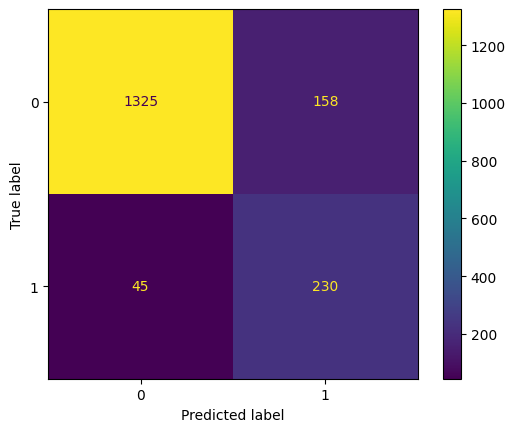

In [179]:
cm = confusion_matrix(target_test, predicted_test_opt)

ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=catboost_clf.classes_
).plot();

### Важность признаков лучшей модели

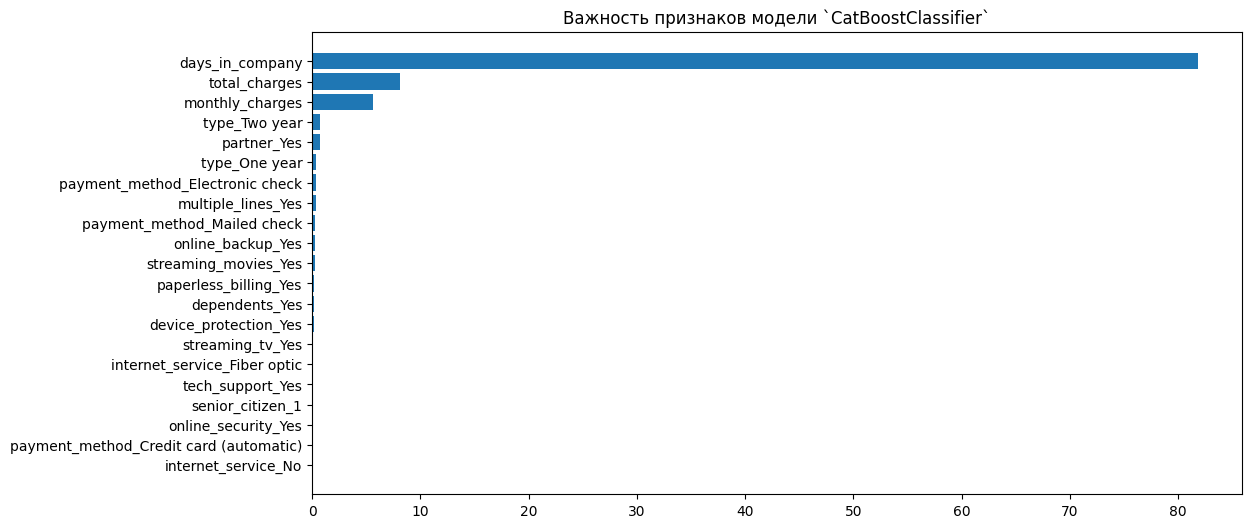

In [180]:
feature_importance = catboost_clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_test_tfr.columns)[sorted_idx])
plt.title('Важность признаков модели `CatBoostClassifier`');

Из анализа графика видно, что:
 - сгенерированный признак `days_in_company` имеет наибольшую и заметно отличающуюся значимость;
 - так же можно отметить что признак `internet_service` имеет наименьшею значимость;
   - отметим, что подтверждается предположение о малой важности данного признака при обучении
 - признаки `paperless_billing` и `senior_citizen` из предположения о малой важности для обучения так же не относятся к наиболее важным признакам модели.

## Отчёт по исследованию

### Постановка задачи

**Разработка модели прогнозирования оттока клиентов**

Компанией, работающей в сфере телекоммуникационных услуг связи, была поставлена задача научиться прогонозировать отток клиентов. Результаты прогнозирования планируется использовать для удержания клиентов. Для проведения исследования компанией были предоставлены обезличенные персональные данные о некоторых клиентах, информация об их тарифах и договорах.


**Описание данных**

Данные состоят из файлов (датасетов), полученных из разных источников:
- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

**Описание некоторых признаков:**
 - `BeginDate` – дата начала пользования услугами,
 - `EndDate` – дата окончания пользования услугами,
 - `Type` – тип оплаты: ежемесячный, годовой и тд,
 - `PaperlessBilling` – безналичный расчет,
 - `PaymentMethod` – способ оплаты,
 - `MonthlyCharges` – ежемесячные траты на услуги,
 - `TotalCharges` – всего потрачено денег на услуги
 - `Dependents` – наличие иждивенцев
 - `Senior Citizen` – наличие пенсионного статуса по возрасту
 - `Partner` – наличие супруга(и)
 - `MultipleLines` – наличие возможности ведения параллельных линий во время звонка



**Были поставлены следующие цели проекта:**
 - разработать модель прогнозирования оттока клиентов;
 - для оценки качества модели применять метрику `ROC AUC`;
 - итоговое значение метрики `ROC AUC` не должно быть меньше `0.85` на тестовом наборе данных;
 - оптимальный срок разработки модели прогнозирования, удовлетворяющей требованиям,- 1 неделя.

### План работ

 1. Исследовательский анализ данных:
   - предварительный анализ исходных данных;
   - полноценный исследовательский анализ: выявление закономерностей в данных и построение портрета клиента;
 2. Предобработка данных:
   - объединение датасетов;
   - обработка пропусков;
   - создание новых признаков;
   - удаление неинформативных признаков;
   - разделение датасета на обучающую и тестувую выборки;
   - подготовка признаков для обучения:
      - кодирование категориальных признаков;
      - масштабирование количественных признаков;
 3. Обучение моделей:
   - выбор моделей для обучения;
   - обучение моделей;
 4. Тестирование модели, показавшей лучший результат при обучении.

### Результаты предварительного анализа исходных данных

В ходе предварительного анализа были изучены исходные данные. В передоставленном наборе данных о клиентах находятся 4 датасета со следующими характеристиками клиентов:

1. Датасет `contract` (файл `contract_new.csv`) — информация о договоре:
| Название признака | Описание признака | Тип данных/ возможные значения |
| :---------------------- | :---------------------- | :---------------------- |
| `customerID` | код клиента | уникальные идентификаторы |
| `BeginDate` | дата начала пользования услугами | даты от `2013-10-01` до `2020-01-01` |
| `EndDate` | дата окончания пользования услугами | значение `No` и даты от `2014-06-01` до `2020-01-01` |
| `Type` | тип оплаты: ежемесячный, годовой и тд | 'Month-to-month', 'One year', 'Two year' |
| `PaperlessBilling` | безналичный расчет | 'Yes', 'No' |
| `PaymentMethod` | способ оплаты | 'Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)' |
| `MonthlyCharges` | ежемесячные траты на услуги | числа в диапазоне от 18.25 до 118.75 |
| `TotalCharges` | всего потрачено денег на услуги | числа в диапазоне от 19.05 до 9221.38 |


2. Датасет `personal` (файл`personal_new.csv`) — персональные данные клиента:
| Название признака | Описание признака | Тип данных/ возможные значения |
| :---------------------- | :---------------------- | :---------------------- |
| `customerID` | код клиента | уникальные идентификаторы |
| `gender` | пол | 'Female', 'Male' |
| `SeniorCitizen` | наличие пенсионного статуса по возрасту | 0, 1 |
| `Partner` | наличие супруга(и) | 'Yes', 'No' |
| `Dependents` | наличие иждивенцев | 'Yes', 'No' |


3. Датасет `internet` (файл `internet_new.csv`) — информация об интернет-услугах:
| Название признака | Описание признака | Тип данных/ возможные значения |
| :---------------------- | :---------------------- | :---------------------- |
| `customerID` | код клиента | уникальные идентификаторы |
| `InternetService` | пользование услогой | 'DSL', 'Fiber optic' |
| `OnlineSecurity` | пользование услогой | 'Yes', 'No' |
| `OnlineBackup` | пользование услогой | 'Yes', 'No' |
| `DeviceProtection` | пользование услогой | 'Yes', 'No' |
| `TechSupport` | пользование услогой | 'Yes', 'No' |
| `StreamingTV` | пользование услогой | 'Yes', 'No' |
| `StreamingMovies` | пользование услогой | 'Yes', 'No' |


4. Датасет `phone` (файл `phone_new.csv`) — информация об услугах телефонии:
| Название признака | Описание признака | Тип данных/ возможные значения |
| :---------------------- | :---------------------- | :---------------------- |
| `customerID` | код клиента | уникальные идентификаторы |
| `MultipleLines` | наличие возможности ведения параллельных линий во время звонка | 'Yes', 'No' |


В результате предварительного исследования установлено, что предоставленные датасеты содержат валидную информацию, а так же, что большая часть данных не содержит пропусков (только признак `TotalCharges` содержит незначительно количество пропусков - 11)

### Результат обработки данных 

#### Объединений датасетов и обработка пропусков

Далее при подготовке к полноценному исследовательскому анализу 4 датасета были объединены в один по признаку `customerID`, который является общим для всех датасетов.

В результате объединения в итоговом датасете образовались пропуски, причиной которым стало наличие информации не о всех клиентах в датасетах `internet` и `phone` по сравнению с датасетами `contract` и `personal`, что означает, что клиенты не пользовались услугами. описанными в датасетах `internet` и `phone`.
Пропуски образовались в признакак:
 - `customerID`, `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies` из датасета `internet`: это бинарные признаки, их необходимо заполнять уже присутствующим в них значением `No`
 - `MultipleLines` из датасета `phone`: в исходном датасете это бинарный признак, но в объединённом он становитс номинальными с тремя категориями: две иходные категории `Yes`, `No` и новая категория в объединённом датасете взамен пропусков может быть отмечена как `not used`, что и будет означать, что клиент не пользуется этой услугой.

#### Подготовка целевого признака

В предоставленных датасетах отсутствовал явно определённый целевой признак и далее он был подготовлен на основе признака `EndDate`. В объединённый датасет добавлен целевой признак `target` со значениями:
 - `0` - клиент, всё ещё пользующиеся услугами компании на момент выгрузки даннных;
 - `1` - клиент не польуется услугами.

Целевой признак имеет дисбаланс классов:
`0` - 84 %
`1` - 16 %

#### Создание нового признака

После проведения анализа исходных данных был создан новый признак на основе разности значений признаков `BeginDate` и `EndDate`, разность вычислялась в днях, новый признак был сохранён с названием `days_in_company`. Данный признак показывает сколько дней клиент пользуется услугами компании.

#### Удаление неинформативных признаков

Далее из итогового датасета были удалены следующие признаки:
    - `customerID` как неинформативный признак;
    - `BeginDate`, `EndDate` как неинформативные признаки для задачи текущего исследования (признаки с датами являются важными для задач исследования временных рядов), и с целью устранения утечки целевого признака при обучении.

#### Анализ признаков: выявление закономерностей в данных

Далее в исследовании был проведён анализ распределений признаков в зависимости от значения целевого признака.

##### Количественные признаки

На основе анализа гистограмм количественных признаков сделаны следующие выводы:
 1. распределение признака `days_in_company` для разных значений целевого признака различаются. Другими словами гистограммы показывают разное поведение оставшихся и ушедших клиентов. Следовательно, можно предположить, что этот признак будет значим при обучении;
 2. формы распределений признака `total_charges` для разных значений целевого признака имеют явно выраженные различия, что также говорит о разном поведении клиентов;
 3. формы распределений признака `monthly_charges` для разных значений целевого признака схожи, при этом отличаются по амплитуде.

##### Категориальные признаки

По итогам анализа распределний категориальных признаков сделаны следующие выводы:
 1. 
    - ряд признаков имеют __схожие распределения__ значений при разных значения целевого признака, это признаки:
        - `paperless_billing`
        - `gender`
        - `senior_citizen`
        - `internet_service`
    - это говорит об отсутствие различий в поведении ушедших/оставшихся клиентов по данным характеристикам;
    - можно предположить, что данные признаки будут иметь малую важность при обучении;
 2. 
    - оставшиеся признаки имеют __разные распределения__ значений при разных значениях целевого признака, что говорит о различном поведении ушедших/оставшихся клиентов по данным характеристикам и соответственно можно предположить, что эти признаки будут иметь более высокую важность при обучении.

#### Анализ корреляции признаков

Следующим шагом был проведён анализ корреляции признаков с использованием коэффициента корреляции $\phi_K$ (библиотека [phik](https://phik.readthedocs.io/en/latest/), созданная на основе научной работы [A new correlation coefficient between categorical, ordinal and interval variables with Pearson characteristics](https://arxiv.org/abs/1811.11440)), который позволяет определить коэффициент корреляции не только между количественными признакми, но и между количественным и категориальным признаками.

Ниже представлены матрица коэффициентов корреляции и матрица значимости коэффиуиентов корреляции.

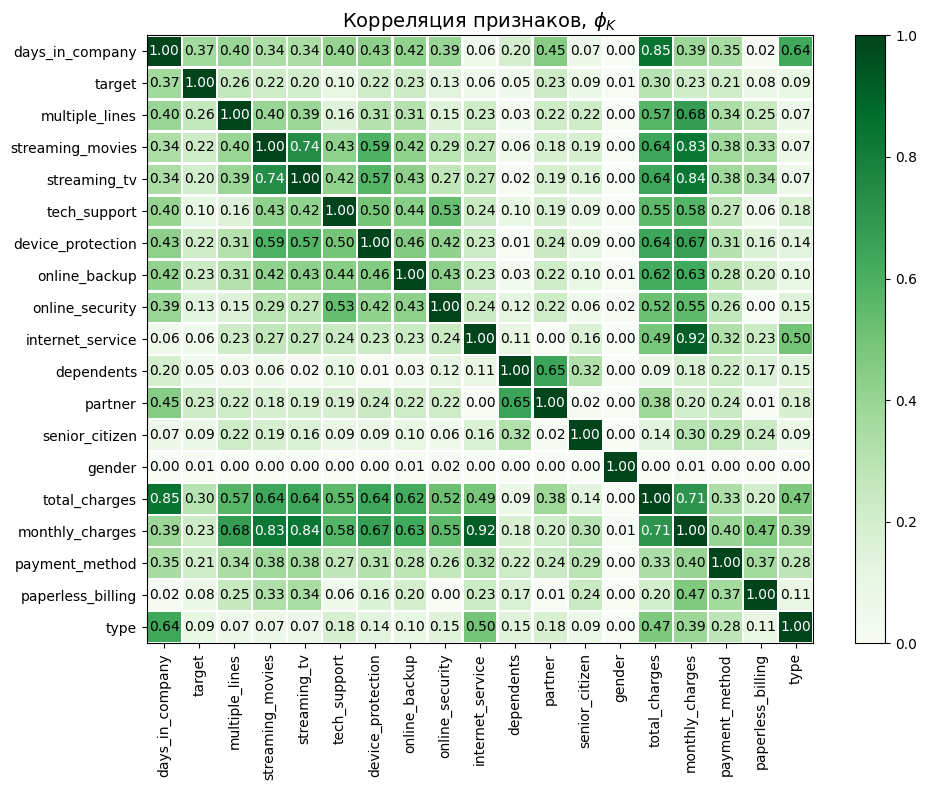

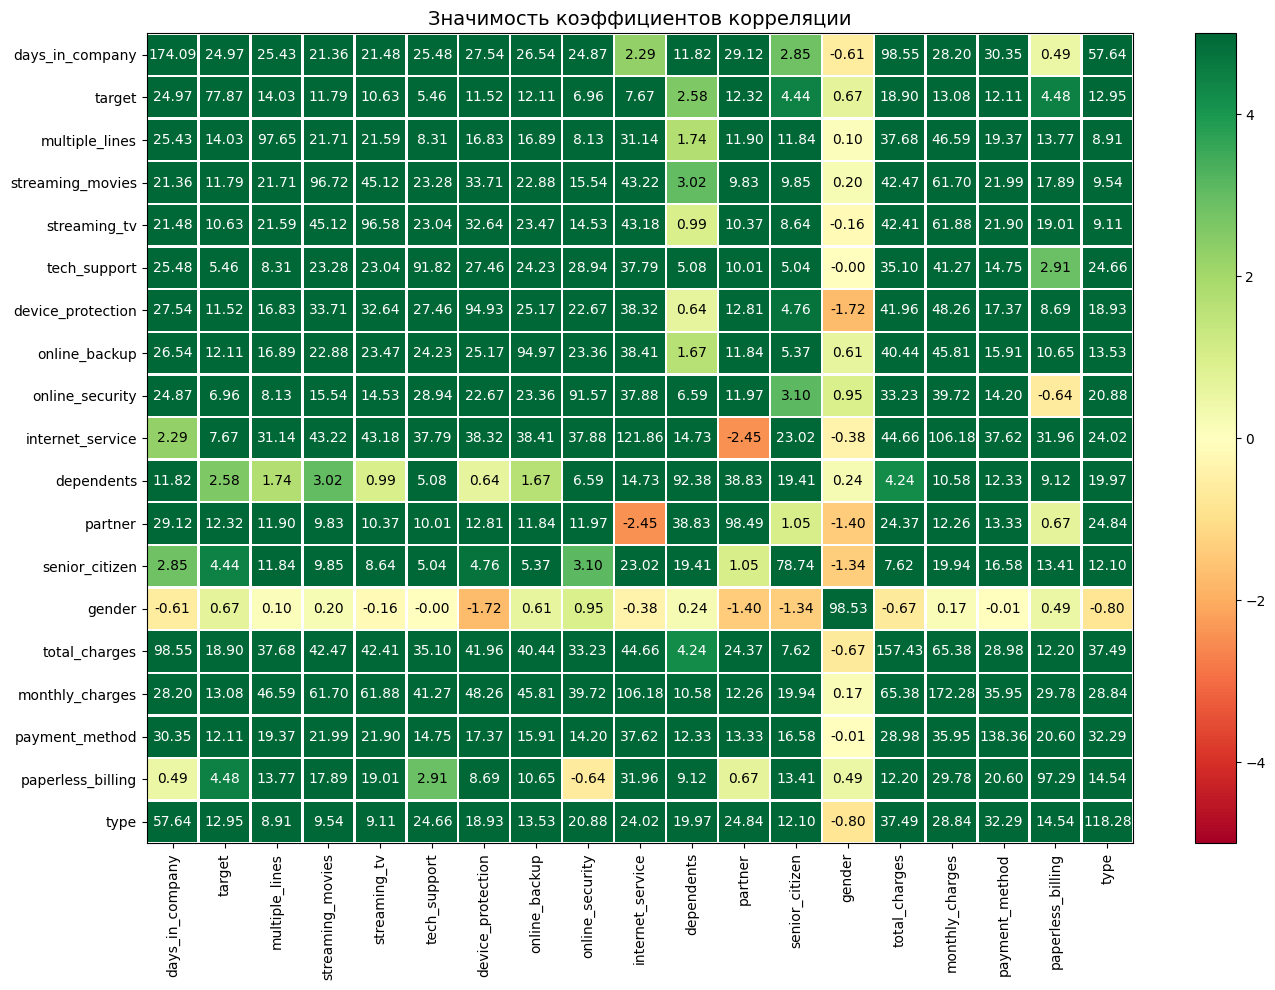


Из анализа матриц обнаружено, что
 - следующие признаки имеют сильную корреляцию:
    - `total_charges` и `days_in_company`
    - `monthly_charges` с признаками`streaming_movies`, `streaming_tv`, `internet_service`
 - признак `gender` практически не имеет взаимосвязи с другими признаками, - на основе этого было принято решение об удалении этого признака из датасета.

#### Подготовка признаков для обучения

Последними шагами в предобработке данных были:
- разделение датасета на обучающую и тестовую выборки;
- подготовка признаков для обучения:
    - кодирование категориальных признаков;
    - масштабирование количественных признаков;

Разделение датасета на обучающую и тестовую выборки делалось с коэффициеном 0.25. Так же при разделение на выборки учитывалс исбаланс классов целевой переменной.

Для кодирования категориальных признаков применялся [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

Для мастшабирования количественных признаков использовался [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

В итоговый набор признаков перед обучением моделей вошли следующие:
 - категориальные:
     - `type`,
     - `paperless_billing`,
     - `payment_method`,
     - `senior_citizen`,
     - `partner`,
     - `dependents`,
     - `internet_service`,
     - `online_security`,
     - `online_backup`,
     - `device_protection`,
     - `tech_support`,
     - `streaming_tv`,
     - `streaming_movies`,
     - `multiple_lines`
 - количественные:
    - `monthly_charges`,
    - `total_charges`,
    - `days_in_company`
    
    
По итогам анализа корреляции признакоы признаков и влияния признаков на целевую переменную для обучения были выбраны почти все исходные признаки за исключением признаков:
 - `customer_id`, который является неинформативным признаком,
 - `begin_date`, `end_date`, которые так же неинформативны для данного типа задачи, и дополнительно могут привести к утечке целевого признака,
 - и признака `gender`, который, как было обнаружено, не имеет взаимосвязи с другими признаками.

### Обучение моделей

Для обучения была выбрана простая линейная модель логистической регрессии с l2 регуляризацией. Далее, так как от заказчика не было требования об интерпретируемости модели, были выбраны модели `RandomForestClassifier` и классификаторы из пакетов с бустингами `CatBoostClassifier`, `XGBClassifier`,  `LGBMClassifier`.

Для подбора гиперпараметров моделй была использована библиотека [Optune](https://optuna.readthedocs.io/en/stable/)

Результаты обучения моделей представлены в таблице ниже:

| model | AUC-ROC |
| :---------------------- | :---------------------- |
| LogisticRegression | 0.7622 |
| RandomForestClassifier | 0.8176 |
| CatBoostClassifier | 0.9224 |
| XGBClassifier | 0.9207 |
| LGBMClassifier | 0.8742 |

 - лучшей моделью на обучении стала модель `CatBoostClassifier`;
 - близкое качество к лучшей модели покази так же модели с бустнигами `XGBClassifier` и `LGBMClassifier`;
 - худшее качество показала линейная модель `LogisticRegression`.

### Результаты тестирование лучшей модели

Для модели `CatBoostClassifier` были определены следующие оптимальные гипер параметры:

```
{
 'iterations': 755,
 'learning_rate': 0.28714066045936953,
 'depth': 2,
 'l2_leaf_reg': 2.753492168065355
}
```

Метрика `ROC AUC` на тестовой выборке составила `0.931`.

Дополнительно на тестовой выборке были определены метрики:
 - `accuracy` = `0.937`
 - `precision` = `0.97`
 - `recall` = `0.62`


И расчитана матрица ошибок:


![%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5.png](attachment:%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5.png)

Видно, что наименьшее значение имеет метрика `recall` - полнота, - сколько объектов класса `1` модель дейтвительно определила как объекты этого класса. Эта метрика так же может являться важной для данной задачи и при необходимости увеличения её значения у полученной модели нужно понижать веротяностный порог классификации.


Так же проведён анализ важности признаков лучшей модели.

На графике ниже представлен список признаков с оценками важности в модели `CatBoostClassifier`.


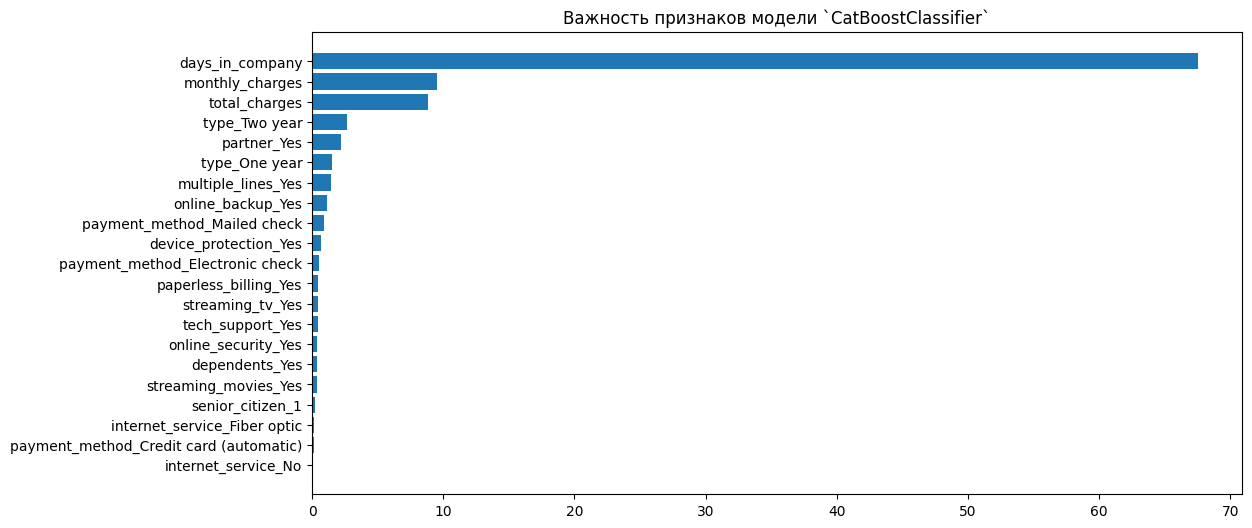

На графике можно выделить следующие группы признаков по важности:
 - максимальную и заметно отличающуюся значимость имеет сгенерированный признак `days_in_company` - значение около 70;
 - группа из 2-х признаков `monthly_charges` и `total_charges` - значение около 10;
 - оставшиеся признаки - значение меньше 3.

### Рекомендации по использованию модели

После тестрования модели в процессе анализа матрицы ошибок было обнаружено, что наименьшее значение имеет метрика `recall` - полнота, - сколько объектов класса `1` модель дейтвительно определила как объекты этого класса.

При дальнейшем использовании полученной модели при необходимости увеличения значения указанной метрики нужно понижать веротяностный порог классификации у полученной модели, при этом отслеживать значение метрики `precision`, поскольку снижение порога помимо увеличения  значения метрики `recall` ведёт к уменьшению метрики `precision`

### Общие выводы

 1. По результатам исследования были выполнены все пункты описанные в плане работ.
 2. В ходе исследования возникли и были решены следующие трудности.
    1. После объединения 4 исходных датасетов в итоговом датасете появилось значителное число пропусков в 8 признаках:
       - проблема с пропусками была решена после обсуждении с заказчиком путём заполнения пропущенных значений согласованными корректными значениями;
    2. Следующей немаловажной трудностью была невозможность достижения необходимого по заданию значения качества модели в `0.85` при обучении моделей только на исходных данных (признаках).
       - данная проблема решалась с помощью добавления в датасет новых признаков, сгенерированных на основе исходных. В процессе исследования было сгенерировано несколько новых признаков, обучены модели на новых и исходных признаках, измерено качество моделей. По результатам в итоговое решение попал только один новый признак (`days_in_company` - сколько дней клиент пользуется услугами компании), давший наибольший прирост по качеству для моделей. Часть исследования с генеррацией других признаков опущена в проекте по причине малой информативности.
 3. Ключевыми шаги в процессе исследования были:
    1. В разделе подготовки данных:
       - непосредственно сам анализ данных и выявление закономерностей в данных, что позволило сделать вывод о валидности и пригодности данных для проведения дальнейшего исследования;
       - создание нового признака, что позволило значительно увеличить качество модели и достигнуть цели по значению метрики качества не меньше `0.85`;
    2. В разделе обучения моделей ключевым шагом стал подбор гипер параметров моделей, что так же позволило повысить качество обучения моделей.
 4. По результатам исследования были достигнуты все цели проекта, обозначенные заказчиком:
    - разработана модель прогнозирования оттока клиентов;
    - удалось получить значение метрики качества модели `ROC AUC` больше `0.85`, оно составило `0.93`;
    - срок разработки не привысил 1 неделю.